## Imports

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb


# Using unpreprocessed data

## Data loading

In [5]:
train_data = pd.read_csv('../data/train.csv')


### Data split

In [7]:
# Check for missing values
print(train_data.isnull().sum())

# Fill missing values or drop them
train_data.fillna(train_data.median(), inplace=True)

# Encoding categorical variables if necessary
# Here, I'm assuming there are categorical variables. Adjust as per your dataset.
train_data = pd.get_dummies(train_data)

# Ensure train and test data have the same columns
# train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# Separate features and target
X = train_data.drop('smoking', axis=1)
y = train_data['smoking']


id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Model - XGBRegressor

In [10]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f'XGBoost RMSE: {xgb_rmse}')


XGBoost RMSE: 0.38725767399198574


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize the model
xgb = XGBRegressor(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=2, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_xgb_best


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


KeyboardInterrupt: 

## NN - ROC - 0.80623

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

# Define the model architecture
model = Sequential()
model.add(Dense(22, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3982/3982 - 5s - 1ms/step - AUC: 0.5791 - loss: 25.4712 - val_AUC: 0.6353 - val_loss: 5.3111
Epoch 2/100
3982/3982 - 4s - 931us/step - AUC: 0.6295 - loss: 5.8477 - val_AUC: 0.7828 - val_loss: 1.4889
Epoch 3/100
3982/3982 - 4s - 909us/step - AUC: 0.6478 - loss: 4.3028 - val_AUC: 0.5896 - val_loss: 6.2866
Epoch 4/100
3982/3982 - 4s - 920us/step - AUC: 0.6593 - loss: 2.8470 - val_AUC: 0.6928 - val_loss: 2.1983
Epoch 5/100
3982/3982 - 4s - 902us/step - AUC: 0.6697 - loss: 1.7914 - val_AUC: 0.6107 - val_loss: 2.8768
Epoch 6/100
3982/3982 - 4s - 906us/step - AUC: 0.6945 - loss: 1.1439 - val_AUC: 0.7955 - val_loss: 0.5918
Epoch 7/100
3982/3982 - 4s - 909us/step - AUC: 0.6996 - loss: 0.6693 - val_AUC: 0.5453 - val_loss: 0.6778
Epoch 8/100
3982/3982 - 4s - 908us/step - AUC: 0.5928 - loss: 0.6743 - val_AUC: 0.5315 - val_loss: 0.6778
Epoch 9/100
3982/3982 - 4s - 891us/step - AUC: 0.5335 - loss: 0.6777 - val_AUC: 0.5187 - val_loss: 0.6817
Epoch 10/100
3982/3982 - 4s - 907us/step - AUC: 0.5130 - lo

In [17]:
X_test = pd.read_csv('../data/test.csv')

In [19]:
X_test

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,265422,40,165,60,78.0,0.8,0.9,1,1,112,...,82,59,149,16.4,1,1.1,24,31,28,0
106167,265423,40,170,85,95.0,1.2,1.2,1,1,130,...,186,44,100,16.0,2,1.0,25,31,38,0
106168,265424,35,170,85,89.0,1.2,1.2,1,1,131,...,76,53,142,15.9,1,0.8,33,32,24,1
106169,265425,40,160,60,67.0,0.7,0.8,1,1,120,...,81,55,103,13.9,1,0.6,42,36,32,0


In [20]:
X_test = pd.read_csv('../data/test.csv')
y_test_pred_prob = model.predict(X_test)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step


## NN - ROC - 0.83979

In [22]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3982/3982 - 8s - 2ms/step - AUC: 0.6268 - loss: 0.6707 - val_AUC: 0.8002 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 2/100
3982/3982 - 6s - 2ms/step - AUC: 0.7553 - loss: 0.5759 - val_AUC: 0.8159 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 3/100
3982/3982 - 7s - 2ms/step - AUC: 0.7785 - loss: 0.5531 - val_AUC: 0.7961 - val_loss: 0.5891 - learning_rate: 0.0010
Epoch 4/100
3982/3982 - 6s - 2ms/step - AUC: 0.7860 - loss: 0.5439 - val_AUC: 0.8061 - val_loss: 0.5647 - learning_rate: 0.0010
Epoch 5/100
3982/3982 - 6s - 2ms/step - AUC: 0.7917 - loss: 0.5383 - val_AUC: 0.7962 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 6/100
3982/3982 - 6s - 2ms/step - AUC: 0.7948 - loss: 0.5338 - val_AUC: 0.8258 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 7/100
3982/3982 - 6s - 1ms/step - AUC: 0.7976 - loss: 0.5302 - val_AUC: 0.8262 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 8/100
3982/3982 - 6s - 2ms/step - AUC: 0.8010 - loss: 0.5263 - val_AUC: 0.8216 - val_loss: 0.5338 - learning_r

In [23]:
X_test = pd.read_csv('../data/test.csv')
y_test_pred_prob = model.predict(X_test)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step


In [31]:
history.history.keys()

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss', 'learning_rate'])

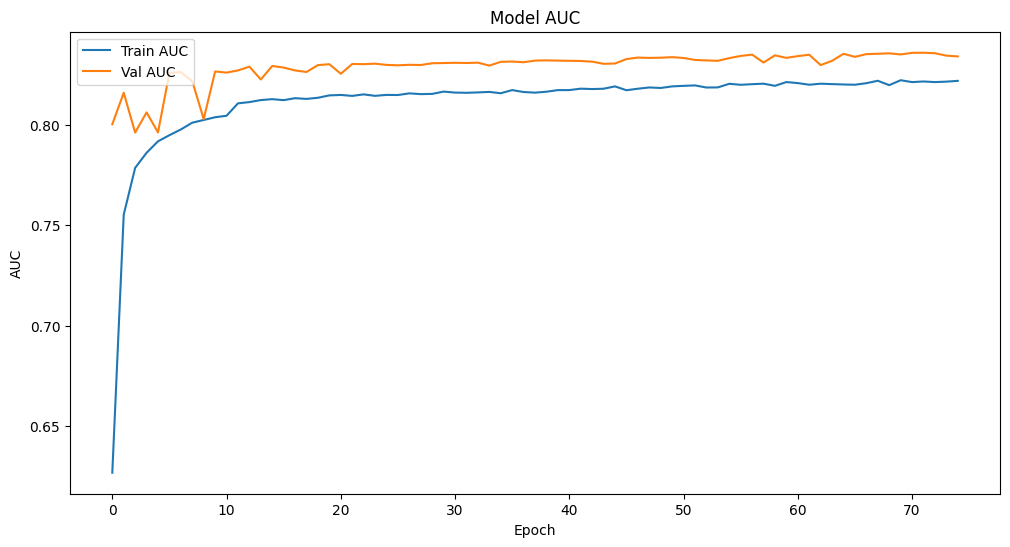

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation AUC values
plt.figure(figsize=(12, 6))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


## NN - ROC - ??

In [ ]:
X_test = pd.read_csv('../data/test.csv')
y_test_pred_prob = model.predict(X_test)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

## XGBoost - ROC - 

In [33]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7803905563229938
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     17783
           1       0.73      0.80      0.76     14069

    accuracy                           0.78     31852
   macro avg       0.78      0.78      0.78     31852
weighted avg       0.79      0.78      0.78     31852



# Using preprocessed data

## Data loading

### Reading the preprocessed csv

In [7]:
train_data = pd.read_csv('../data/train_data_preprocessed.csv')

In [8]:
# Check for missing values
print(train_data.isnull().sum())

# Fill missing values or drop them
train_data.fillna(train_data.median(), inplace=True)

# Encoding categorical variables if necessary
# Here, I'm assuming there are categorical variables. Adjust as per your dataset.
train_data = pd.get_dummies(train_data)

# Ensure train and test data have the same columns
# train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# Separate features and target
X = train_data.drop('smoking', axis=1)
y = train_data['smoking']

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
systolic               0
relaxation             0
fasting blood sugar    0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
BMI                    0
hearing                0
eyesight               0
AST/ALT_ratio          0
smoking                0
dtype: int64


### Splitting it

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Training - NN - ROC - 0.85871

In [38]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4956/4956 - 9s - 2ms/step - AUC: 0.8098 - loss: 0.5155 - val_AUC: 0.8440 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 2/100
4956/4956 - 7s - 1ms/step - AUC: 0.8303 - loss: 0.4894 - val_AUC: 0.8452 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 3/100
4956/4956 - 7s - 1ms/step - AUC: 0.8330 - loss: 0.4868 - val_AUC: 0.8468 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 4/100
4956/4956 - 7s - 1ms/step - AUC: 0.8345 - loss: 0.4847 - val_AUC: 0.8481 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 5/100
4956/4956 - 7s - 1ms/step - AUC: 0.8347 - loss: 0.4839 - val_AUC: 0.8475 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 6/100
4956/4956 - 7s - 1ms/step - AUC: 0.8339 - loss: 0.4851 - val_AUC: 0.8483 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 7/100
4956/4956 - 7s - 1ms/step - AUC: 0.8355 - loss: 0.4837 - val_AUC: 0.8483 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 8/100
4956/4956 - 7s - 1ms/step - AUC: 0.8358 - loss: 0.4833 - val_AUC: 0.8484 - val_loss: 0.4687 - learning_r

In [43]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step


## Training - NN - ROC - 0.85812

In [44]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')

Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4956/4956 - 10s - 2ms/step - AUC: 0.8141 - loss: 0.5094 - val_AUC: 0.8403 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 2/100
4956/4956 - 7s - 1ms/step - AUC: 0.8315 - loss: 0.4887 - val_AUC: 0.8471 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 3/100
4956/4956 - 7s - 1ms/step - AUC: 0.8330 - loss: 0.4869 - val_AUC: 0.8463 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 4/100
4956/4956 - 7s - 1ms/step - AUC: 0.8336 - loss: 0.4859 - val_AUC: 0.8474 - val_loss: 0.4688 - learning_rate: 0.0010
Epoch 5/100
4956/4956 - 7s - 1ms/step - AUC: 0.8343 - loss: 0.4850 - val_AUC: 0.8479 - val_loss: 0.4710 - learning_rate: 0.0010
Epoch 6/100
4956/4956 - 7s - 1ms/step - AUC: 0.8348 - loss: 0.4837 - val_AUC: 0.8475 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 7/100
4956/4956 - 7s - 1ms/step - AUC: 0.8354 - loss: 0.4838 - val_AUC: 0.8484 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 8/100
4956/4956 - 8s - 2ms/step - AUC: 0.8357 - loss: 0.4833 - val_AUC: 0.8471 - val_loss: 0.4698 - learning_

In [97]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step


ValueError: array length 1698736 does not match index length 106171

### plots

In [101]:
model

<Sequential name=sequential_10, built=True>

[64, 32, 16, 1]


In [81]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

In [ ]:
# Get the list of layers
layers = model.layers

# Extract the number of neurons for each layer that has neurons
layer_neurons = []
layers_found = []
for layer in layers:
    if hasattr(layer, 'units'):
        layers_found.append(layer.units)

print(layers_found)

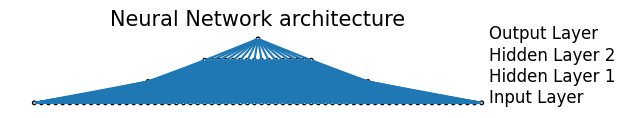

In [107]:
network = DrawNN(layers_found)
network.draw()

In [73]:
network = DrawNN( [2,8,8,1] )
network.draw()

NameError: name 'xrange' is not defined

## NN - MULTITHREADING - ROC - ???

In [108]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score

# Set up the distribution strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4956/4956 - 11s - 2ms/step - AUC: 0.8094 - loss: 0.5170 - val_AUC: 0.8411 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 2/100
4956/4956 - 8s - 2ms/step - AUC: 0.8302 - loss: 0.4898 - val_AUC: 0.8454 - val_loss: 0.4718 - learning_rate: 0.0010
Epoch 3/100
4956/4956 - 8s - 2ms/step - AUC: 0.8328 - loss: 0.4865 - val_AUC: 0.8468 - val_loss: 0.4697 - learning_rate: 0.0010
Epoch 4/100
4956/4956 - 8s - 2ms/step - AUC: 0.8345 - loss: 0.4842 - val_AUC: 0.8451 - val_loss: 0.4722 - learning_rate: 0.0010
Epoch 5/100
4956/4956 - 8s - 2ms/step - AUC: 0.8342 - loss: 0.4849 - val_AUC: 0.8473 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 6/100
4956/4956 - 8s - 2ms/step - AUC: 0.8337 - loss: 0.4854 - val_AUC: 0.8473 - val_loss: 0.4713 - learning_rate: 0.0010
Epoch 7/100
4956/4956 - 8s - 2ms/step - AUC: 0.8348 - loss: 0.4841 - val_AUC: 0.8478 - val_loss: 0.4719 - learning_rate: 0.0010
Epoch 8/100
4956/4956 - 8s - 2ms/step - AUC: 0.8356 - loss: 0.4829 - val_AUC: 0.8454 - val_loss: 0.4756 - learning_

In [109]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


# Using pipelines

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score

## Preprocessing

### MinMaxScaler

### StandardScaler

## NN with pipeline: config dodaj

In [ ]:

# Custom transformer to remove columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1)

# Custom transformer to remove outliers
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3.0):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        z_scores = np.abs((X - X.mean()) / X.std())
        return X[(z_scores < self.threshold).all(axis=1)]

# Load datasets
train = pd.read_csv("../data/data_merged.csv")
test = pd.read_csv("../data/test.csv")

# Define columns to drop (example: 'col1', 'col2')
columns_to_drop = ['col1', 'col2']

# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('drop_columns', ColumnDropper(columns_to_drop=columns_to_drop)),
    ('remove_outliers', OutlierRemover(threshold=3.0)),
    ('scaler', StandardScaler())
])

# Split the train dataset into features and target
X = train.drop('target', axis=1)
y = train['target']

# Preprocess the data
X_preprocessed = preprocessing_pipeline.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


# Testing different combinations

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle
import os


In [3]:
train = pd.read_csv("../data/data_merged.csv")
test = pd.read_csv("../data/test.csv")

### Helper functions

In [25]:
def remove_outliers(df, y, n_sigma):
    mask = (np.abs(df - df.mean()) <= (n_sigma * df.std())).all(axis=1)
    return df[mask], y[mask]

def replace_outliers(df, n_sigma):
    mean = df.mean()
    std = df.std()
    mask = (np.abs(df - mean) > (n_sigma * std))
    df_replaced = df.copy()
    for col in df.columns:
        col_mask = mask[col]
        df_replaced.loc[col_mask, col] = df_replaced.loc[~col_mask, col].ffill().bfill()
    return df_replaced

def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop)

# Model definitions
def create_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    predictions = model.predict(X_val).ravel()
    return roc_auc_score(y_val, predictions)

def save_preprocessed_data(X, y, sigma, columns_to_drop, method):
    # Create the directory if it does not exist
    os.makedirs('./preprocessed', exist_ok=True)
    
    # Combine X and y into a single DataFrame
    data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    data['target'] = y.values
    
    # Construct the filename
    filename = f'preprocessed_sigma{sigma}_drop{len(columns_to_drop)}_{method}.csv'
    
    # Save the dataframe as a CSV file
    data.to_csv(f'./preprocessed/{filename}', index=False)

def plot_distributions(data, sigma, columns_to_drop, method):
    plt.figure(figsize=(15, 10))
    num_vars = data.shape[1]
    for i, column in enumerate(data.columns):
        plt.subplot((num_vars // 3) + 1, 3, i + 1)
        sns.histplot(data[column], kde=True)
        plt.title(column)
    plt.tight_layout()
    plt.savefig(f'distribution_sigma{sigma}_drop{len(columns_to_drop)}_{method}.png')
    plt.close()


## Setting values to test

In [16]:
sigma_values = [1, 2, 3, 4]
columns_to_drop_list = [
    ['hearing(left)', 'hearing(right)', 'eyesight(left)', 'eyesight(right)', 'Cholesterol'],
    ['hearing(left)', 'hearing(right)', 'eyesight(left)', 'eyesight(right)']
]
outlier_methods = ['drop', 'replace']

In [6]:
X = train.drop(columns=['smoking'])  # Assuming 'target' is the label column
y = train['smoking']

## Testing

In [28]:
for sigma in sigma_values:
    for columns_to_drop in columns_to_drop_list:
        for method in outlier_methods:
            # Preprocessing
            if method == 'drop':
                X_processed, y_processed = remove_outliers(X, y, sigma)
            elif method == 'replace':
                X_processed = replace_outliers(X, sigma)
                y_processed = y[X_processed.index]

            X_processed = drop_columns(X_processed, columns_to_drop)
            save_preprocessed_data(X_processed, y_processed, sigma, columns_to_drop, method)

            # Standardization
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_processed)
            
            preprocessed_data.append((X_scaled, y_processed, sigma, columns_to_drop, scaler, method))
            
            # Plotting distributions
            plot_distributions(pd.DataFrame(X_scaled, columns=X_processed.columns), sigma, columns_to_drop, method)


### plots

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def plot_distributions(data, sigma, columns_to_drop):
    plt.figure(figsize=(15, 10))
    num_vars = data.shape[1]
    for i, column in enumerate(data.columns):
        plt.subplot((num_vars // 3) + 1, 3, i + 1)
        sns.histplot(data[column], kde=True)
        plt.title(column)
    plt.tight_layout()
    plt.savefig(f'distribution_sigma{sigma}_drop{len(columns_to_drop)}.png')
    plt.close()


In [15]:
for sigma in sigma_values:
    for columns_to_drop in columns_to_drop_list:
        # Preprocessing
        X_processed, y_processed = remove_outliers(X, y, sigma)
        X_processed = drop_columns(X_processed, columns_to_drop)
        save_preprocessed_data((X_processed, y_processed), f'preprocessed_data_sigma{sigma}_drop{len(columns_to_drop)}.pkl')

        # Standardization
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_processed)
        
        preprocessed_data.append((X_scaled, y_processed, sigma, columns_to_drop, scaler))
        
        # Plotting distributions
        plot_distributions(pd.DataFrame(X_scaled, columns=X_processed.columns), sigma, columns_to_drop)


## Training

In [8]:
# Model building and evaluation step
results = []

for X_scaled, y_processed, sigma, columns_to_drop, scaler in preprocessed_data:
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_processed, test_size=0.2, random_state=42)

    # Neural Network
    model_nn = create_neural_network(X_train.shape[1])
    auc_nn = evaluate_model(model_nn, X_train, y_train, X_val, y_val)
    results.append(('NN', sigma, columns_to_drop, auc_nn))

    # Random Forest
    model_rf = RandomForestClassifier()
    model_rf.fit(X_train, y_train)
    predictions_rf = model_rf.predict_proba(X_val)[:, 1]
    auc_rf = roc_auc_score(y_val, predictions_rf)
    results.append(('RF', sigma, columns_to_drop, auc_rf))

    # Logistic Regression
    model_lr = LogisticRegression(max_iter=1000)
    model_lr.fit(X_train, y_train)
    predictions_lr = model_lr.predict_proba(X_val)[:, 1]
    auc_lr = roc_auc_score(y_val, predictions_lr)
    results.append(('LR', sigma, columns_to_drop, auc_lr))

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
# Print results
for result in results:
    print(f"Model: {result[0]}, Sigma: {result[1]}, Columns Dropped: {result[2]}, AUC: {result[3]}")


# Fast training test

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score

# Ensure TensorFlow uses GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [31]:
# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid', dtype='float32'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')

Epoch 1/50


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1363/1363 - 4s - 3ms/step - AUC: 0.7918 - loss: 0.5391 - val_AUC: 0.8292 - val_loss: 0.4938 - learning_rate: 0.0010
Epoch 2/50
1363/1363 - 2s - 1ms/step - AUC: 0.8172 - loss: 0.5064 - val_AUC: 0.8327 - val_loss: 0.4891 - learning_rate: 0.0010
Epoch 3/50
1363/1363 - 2s - 1ms/step - AUC: 0.8228 - loss: 0.5000 - val_AUC: 0.8348 - val_loss: 0.4869 - learning_rate: 0.0010
Epoch 4/50
1363/1363 - 2s - 1ms/step - AUC: 0.8255 - loss: 0.4970 - val_AUC: 0.8356 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 5/50
1363/1363 - 2s - 2ms/step - AUC: 0.8273 - loss: 0.4955 - val_AUC: 0.8364 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 6/50
1363/1363 - 2s - 2ms/step - AUC: 0.8278 - loss: 0.4947 - val_AUC: 0.8375 - val_loss: 0.4838 - learning_rate: 0.0010
Epoch 7/50
1363/1363 - 2s - 2ms/step - AUC: 0.8281 - loss: 0.4939 - val_AUC: 0.8370 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 8/50
1363/1363 - 2s - 1ms/step - AUC: 0.8297 - loss: 0.4929 - val_AUC: 0.8380 - val_loss: 0.4836 - learning_rate: 0.

# Training on multiple csv

In [20]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, Manager
from tqdm import tqdm

# Ensure the models directory exists
os.makedirs('./models', exist_ok=True)

# # Custom callback to update tqdm progress bar
# class TQDMProgressCallback(Callback):
#     def __init__(self, tqdm_instance, file):
#         super().__init__()
#         self.tqdm_instance = tqdm_instance
#         self.file = file

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         self.tqdm_instance.set_description(f"Processing {self.file} | Epoch {epoch+1} | Loss: {logs.get('loss'):.4f} | AUC: {logs.get('auc'):.4f} | Val_Loss: {logs.get('val_loss'):.4f} | Val_AUC: {logs.get('val_auc'):.4f}")
#         self.tqdm_instance.update(1)

# Function to train the model
def train_model(file):
    # Load the data
    data = pd.read_csv(f'./preprocessed/{file}')
    X = data.drop(columns=['target'])
    y = data['target']
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
    
    # Define early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model with tqdm progress bar
    epochs = 50
    model.fit(X_train, y_train, epochs=epochs, batch_size=64,
                            validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
    
    # Predict on validation set
    y_pred_prob = model.predict(X_val)
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    # Save the model
    model_filename = f'./models/{os.path.splitext(file)[0]}.h5'
    model.save(model_filename)
    
    # Update the main progress queue with the result
    # progress_queue.put((file, roc_auc))

In [21]:
def main():
    # List all CSV files in the preprocessed directory
    preprocessed_dir = './preprocessed/'
    files = [f for f in os.listdir(preprocessed_dir) if f.endswith('.csv')]
    
    # Create a manager to handle progress tracking
    manager = Manager()
    progress_queue = manager.Queue()
    
    # Add initial position indexes to the queue
    # for idx in range(len(files)):
    #     progress_queue.put(idx)
    
    for file in files:
        print(f"Using {file} as the input file.")
        train_model(file)
    
    # Print the results
    for file, roc_auc in results:
        print(f'File: {file}, Neural Network ROC AUC: {roc_auc}')

In [22]:
main()

Using preprocessed_sigma1_drop4_drop.csv as the input file.
Epoch 1/50


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.4831 - loss: 0.6913 - val_AUC: 0.5000 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4897 - loss: 0.6844 - val_AUC: 0.5000 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5275 - loss: 0.6870 - val_AUC: 0.5000 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4806 - loss: 0.6798 - val_AUC: 0.5000 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4862 - loss: 0.6777 - val_AUC: 0.5000 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.4795 - loss: 0.6823 - val_AUC: 0.5000 - val_loss: 0.6895 - learning_rate: 2.0000e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5147 - loss: 0.6813 - val_AUC: 0.5000 - val_loss: 0.6896 - learning_rate: 2.0000e-04
Epoch 8/50
21/21 ━━━━━

Using preprocessed_sigma1_drop4_replace.csv as the input file.


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.4984 - loss: 0.6821 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4956 - loss: 0.6810 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4993 - loss: 0.6811 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4981 - loss: 0.6810 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4989 - loss: 0.6821 - val_AUC: 0.5000 - val_loss: 0.6829 - learning_rate: 2.0000e-04
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4983 - loss: 0.6815 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 7/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4974 - loss: 0.6810 - val_AUC: 0.5000 - val_loss: 0.6828 - learni

Using preprocessed_sigma1_drop5_drop.csv as the input file.
Epoch 1/50


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - AUC: 0.4991 - loss: 0.6916 - val_AUC: 0.5000 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.4757 - loss: 0.6892 - val_AUC: 0.5000 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.4962 - loss: 0.6844 - val_AUC: 0.5000 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5079 - loss: 0.6789 - val_AUC: 0.5000 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5036 - loss: 0.6852 - val_AUC: 0.5000 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5014 - loss: 0.6818 - val_AUC: 0.5000 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4665 - loss: 0.6798 - val_AUC: 0.5000 - val_loss: 0.6896 - learning_rate: 2.0000e-04
Epoch 8/50
21/21 ━━━━━━━━━

Using preprocessed_sigma1_drop5_replace.csv as the input file.


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5000 - loss: 0.6820 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5011 - loss: 0.6809 - val_AUC: 0.5000 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4995 - loss: 0.6815 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4976 - loss: 0.6810 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4987 - loss: 0.6809 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5008 - loss: 0.6811 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma2_drop4_drop.csv as the input file.
Epoch 1/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.5024 - loss: 0.6877 - val_AUC: 0.5000 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 2/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4947 - loss: 0.6881 - val_AUC: 0.5000 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 3/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4971 - loss: 0.6872 - val_AUC: 0.5000 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 4/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4989 - loss: 0.6874 - val_AUC: 0.5000 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 5/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4977 - loss: 0.6868 - val_AUC: 0.5000 - val_loss: 0.6876 - learning_rate: 2.0000e-04
Epoch 6/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.5024 - loss: 0.6866 - val_AUC: 0.5000 - val_loss: 0.6877 - learning_rate: 2.0000e-04
Epoch 7/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4988 

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma2_drop4_replace.csv as the input file.
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5000 - loss: 0.6820 - val_AUC: 0.5000 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4999 - loss: 0.6815 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4996 - loss: 0.6809 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5017 - loss: 0.6813 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4977 - loss: 0.6809 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4972 - loss: 0.6815 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 7/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4990 -

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma2_drop5_drop.csv as the input file.
Epoch 1/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.5012 - loss: 0.6873 - val_AUC: 0.5000 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 2/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4998 - loss: 0.6875 - val_AUC: 0.5000 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 3/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4998 - loss: 0.6874 - val_AUC: 0.5000 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 4/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4961 - loss: 0.6871 - val_AUC: 0.5000 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 5/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4980 - loss: 0.6870 - val_AUC: 0.5000 - val_loss: 0.6876 - learning_rate: 2.0000e-04
Epoch 6/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4999 - loss: 0.6871 - val_AUC: 0.5000 - val_loss: 0.6877 - learning_rate: 2.0000e-04
Epoch 7/50
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.4955 

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma2_drop5_replace.csv as the input file.
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - AUC: 0.5012 - loss: 0.6823 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.5021 - loss: 0.6812 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4967 - loss: 0.6815 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5040 - loss: 0.6805 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5032 - loss: 0.6812 - val_AUC: 0.5000 - val_loss: 0.6829 - learning_rate: 2.0000e-04
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4977 - loss: 0.6810 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 7/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.50

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma3_drop4_drop.csv as the input file.
Epoch 1/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.4970 - loss: 0.6819 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 2/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4990 - loss: 0.6808 - val_AUC: 0.5000 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 3/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5009 - loss: 0.6808 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 4/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5002 - loss: 0.6806 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 5/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.4975 - loss: 0.6808 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 2.0000e-04
Epoch 6/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4976 - loss: 0.6813 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 2.0000e-04
Epoch 7/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4979 

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma3_drop4_replace.csv as the input file.
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.4995 - loss: 0.6821 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4997 - loss: 0.6812 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5000 - loss: 0.6808 - val_AUC: 0.5000 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5020 - loss: 0.6823 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4968 - loss: 0.6815 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4995 - loss: 0.6812 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma3_drop5_drop.csv as the input file.
Epoch 1/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5031 - loss: 0.6817 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 2/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5014 - loss: 0.6807 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 3/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4982 - loss: 0.6803 - val_AUC: 0.5000 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 4/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.5020 - loss: 0.6807 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 5/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4999 - loss: 0.6811 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 2.0000e-04
Epoch 6/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4998 - loss: 0.6811 - val_AUC: 0.5000 - val_loss: 0.6809 - learning_rate: 2.0000e-04
Epoch 7/50
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5018 

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma3_drop5_replace.csv as the input file.
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5028 - loss: 0.6817 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4976 - loss: 0.6816 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4987 - loss: 0.6814 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4987 - loss: 0.6817 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5004 - loss: 0.6807 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4997 - loss: 0.6812 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma4_drop4_drop.csv as the input file.
Epoch 1/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.4995 - loss: 0.6830 - val_AUC: 0.5000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4970 - loss: 0.6818 - val_AUC: 0.5000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 3/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5012 - loss: 0.6823 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4972 - loss: 0.6816 - val_AUC: 0.5000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 5/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5006 - loss: 0.6818 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 6/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4989 - loss: 0.6810 - val_AUC: 0.5000 - val_loss: 0.6827 - learning_rate: 2.0000e-04
Epoch 7/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5020 

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma4_drop4_replace.csv as the input file.
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5015 - loss: 0.6816 - val_AUC: 0.5000 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4950 - loss: 0.6817 - val_AUC: 0.5000 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4990 - loss: 0.6817 - val_AUC: 0.5000 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4987 - loss: 0.6818 - val_AUC: 0.5000 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4981 - loss: 0.6807 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4978 - loss: 0.6811 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 7/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4971 - los

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma4_drop5_drop.csv as the input file.
Epoch 1/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.4977 - loss: 0.6821 - val_AUC: 0.5000 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 2/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4963 - loss: 0.6826 - val_AUC: 0.5000 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 3/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5001 - loss: 0.6826 - val_AUC: 0.5000 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 4/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4981 - loss: 0.6817 - val_AUC: 0.5000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 5/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4990 - loss: 0.6826 - val_AUC: 0.5000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 6/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4970 - loss: 0.6820 - val_AUC: 0.5000 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 7/50
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5001 - loss: 

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using preprocessed_sigma4_drop5_replace.csv as the input file.
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5018 - loss: 0.6821 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5056 - loss: 0.6806 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.4998 - loss: 0.6813 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5006 - loss: 0.6814 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.4947 - loss: 0.6808 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.5034 - loss: 0.6814 - val_AUC: 0.5000 - val_loss: 0.6828 - learning_rate: 2.0000e-04
Epoch 7/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.49

NameError: name 'results' is not defined

# NN - ROC - 0.0589

In [12]:
model2 = Sequential()
model2.add(Dense(21, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.1))
model2.add(Dense(21, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(3, activation='relu'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])




# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model2.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)

# Predict on validation set
y_pred_prob = model2.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')

Epoch 1/100
2478/2478 - 4s - 2ms/step - AUC: 0.8308 - loss: 0.4878 - val_AUC: 0.8443 - val_loss: 0.4921
Epoch 2/100
2478/2478 - 3s - 1ms/step - AUC: 0.8439 - loss: 0.4712 - val_AUC: 0.8470 - val_loss: 0.4702
Epoch 3/100
2478/2478 - 3s - 1ms/step - AUC: 0.8467 - loss: 0.4680 - val_AUC: 0.8435 - val_loss: 0.4751
Epoch 4/100
2478/2478 - 3s - 1ms/step - AUC: 0.8475 - loss: 0.4667 - val_AUC: 0.8490 - val_loss: 0.4706
Epoch 5/100
2478/2478 - 3s - 1ms/step - AUC: 0.8478 - loss: 0.4660 - val_AUC: 0.8488 - val_loss: 0.4660
Epoch 6/100
2478/2478 - 3s - 1ms/step - AUC: 0.8487 - loss: 0.4652 - val_AUC: 0.8484 - val_loss: 0.4666
Epoch 7/100
2478/2478 - 3s - 1ms/step - AUC: 0.8490 - loss: 0.4644 - val_AUC: 0.8491 - val_loss: 0.4723
Epoch 8/100
2478/2478 - 2s - 1ms/step - AUC: 0.8493 - loss: 0.4642 - val_AUC: 0.8495 - val_loss: 0.4649
Epoch 9/100
2478/2478 - 3s - 1ms/step - AUC: 0.8497 - loss: 0.4631 - val_AUC: 0.8499 - val_loss: 0.4644
Epoch 10/100
2478/2478 - 3s - 1ms/step - AUC: 0.8494 - loss: 0.4

In [29]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model2.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step


## NN - ROC - ??

In [30]:
model2 = Sequential()
model2.add(Dense(21, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.1))
model2.add(Dense(21, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(3, activation='relu'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])




# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model2.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)

# Predict on validation set
y_pred_prob = model2.predict(X_val)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')

Epoch 1/100
2478/2478 - 5s - 2ms/step - AUC: 0.8265 - loss: 0.4922 - val_AUC: 0.8416 - val_loss: 0.4800
Epoch 2/100
2478/2478 - 3s - 1ms/step - AUC: 0.8407 - loss: 0.4757 - val_AUC: 0.8450 - val_loss: 0.4735
Epoch 3/100
2478/2478 - 3s - 1ms/step - AUC: 0.8435 - loss: 0.4721 - val_AUC: 0.8480 - val_loss: 0.4676
Epoch 4/100
2478/2478 - 3s - 1ms/step - AUC: 0.8451 - loss: 0.4704 - val_AUC: 0.8484 - val_loss: 0.4676
Epoch 5/100
2478/2478 - 3s - 1ms/step - AUC: 0.8467 - loss: 0.4685 - val_AUC: 0.8481 - val_loss: 0.4753
Epoch 6/100
2478/2478 - 3s - 1ms/step - AUC: 0.8473 - loss: 0.4673 - val_AUC: 0.8492 - val_loss: 0.4666
Epoch 7/100
2478/2478 - 3s - 1ms/step - AUC: 0.8475 - loss: 0.4671 - val_AUC: 0.8494 - val_loss: 0.4654
Epoch 8/100
2478/2478 - 3s - 1ms/step - AUC: 0.8485 - loss: 0.4659 - val_AUC: 0.8495 - val_loss: 0.4653
Epoch 9/100
2478/2478 - 3s - 1ms/step - AUC: 0.8477 - loss: 0.4670 - val_AUC: 0.8491 - val_loss: 0.4665
Epoch 10/100
2478/2478 - 3s - 1ms/step - AUC: 0.8483 - loss: 0.4

In [31]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model2.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 653us/step


## NN - z chata - ROC 0.85316

In [32]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model
model2 = Sequential([
    Dense(32, input_dim=X_train.shape[1], kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(32, kernel_regularizer=l2(0.01)),
    Activation('relu'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model2.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=2)

# Evaluate the model
y_pred_prob = model2.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'Neural Network ROC AUC: {roc_auc}')


Epoch 1/100


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4956/4956 - 7s - 1ms/step - AUC: 0.8287 - loss: 0.5240 - val_AUC: 0.8385 - val_loss: 0.4959 - learning_rate: 0.0010
Epoch 2/100
4956/4956 - 5s - 1ms/step - AUC: 0.8352 - loss: 0.4932 - val_AUC: 0.8405 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 3/100
4956/4956 - 5s - 1ms/step - AUC: 0.8373 - loss: 0.4908 - val_AUC: 0.8434 - val_loss: 0.5011 - learning_rate: 0.0010
Epoch 4/100
4956/4956 - 6s - 1ms/step - AUC: 0.8374 - loss: 0.4906 - val_AUC: 0.8414 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 5/100
4956/4956 - 5s - 1ms/step - AUC: 0.8373 - loss: 0.4899 - val_AUC: 0.8419 - val_loss: 0.4925 - learning_rate: 0.0010
Epoch 6/100
4956/4956 - 5s - 1ms/step - AUC: 0.8374 - loss: 0.4899 - val_AUC: 0.8358 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 7/100
4956/4956 - 5s - 1ms/step - AUC: 0.8379 - loss: 0.4893 - val_AUC: 0.8390 - val_loss: 0.4937 - learning_rate: 0.0010
Epoch 8/100
4956/4956 - 6s - 1ms/step - AUC: 0.8377 - loss: 0.4894 - val_AUC: 0.8407 - val_loss: 0.4961 - learning_r

In [33]:
X_test_preprocessed = pd.read_csv('../data/test_data_preprocessed.csv')
X_test = pd.read_csv('../data/test.csv')

y_test_pred_prob = model2.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': X_test['id'],
    'smoking': y_test_pred_prob.flatten()
})

submission.to_csv('submission.csv', index=False)

3318/3318 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step


In [35]:
model2.save("NN - temp.keras")

In [4]:
model2 = Sequential()

In [5]:
model2.load_weights("NN - temp.keras")

# Feature importance

In [1]:

# Assuming `model2` is your trained model
model2.save('model_temp.keras')  # Saves to the SavedModel format by default



NameError: name 'model2' is not defined

In [2]:
from tensorflow.keras.models import load_model


In [10]:
model2 = load_model('model_temp.keras')

In [11]:
import shap
import numpy as np

# Make sure your model is defined and loaded with the trained weights

# Initialize the SHAP Deep Explainer
explainer = shap.DeepExplainer(model2, X_train[:100])  # Using a subset of training data as background

# Compute SHAP values on a subset of validation data for speed reasons
shap_values = explainer.shap_values(X_val[:100])

# Plot the summary plot for the first class (binary classification)
shap.summary_plot(shap_values[0], X_val[:100], feature_names=X_val.columns)


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AttributeError: 'tuple' object has no attribute 'as_list'

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


  1%|          | 1/100 [00:00<00:54,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


  2%|▏         | 2/100 [00:01<00:50,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


  3%|▎         | 3/100 [00:01<00:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


  4%|▍         | 4/100 [00:02<00:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


  5%|▌         | 5/100 [00:02<00:48,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


  6%|▌         | 6/100 [00:03<00:47,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


  7%|▋         | 7/100 [00:03<00:46,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


  8%|▊         | 8/100 [00:04<00:45,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step


  9%|▉         | 9/100 [00:04<00:46,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


 10%|█         | 10/100 [00:05<00:46,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


 11%|█         | 11/100 [00:05<00:45,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


 12%|█▏        | 12/100 [00:06<00:44,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


 13%|█▎        | 13/100 [00:06<00:43,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


 14%|█▍        | 14/100 [00:07<00:43,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


 15%|█▌        | 15/100 [00:07<00:42,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


 16%|█▌        | 16/100 [00:08<00:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 17%|█▋        | 17/100 [00:08<00:41,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


 18%|█▊        | 18/100 [00:09<00:40,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


 19%|█▉        | 19/100 [00:09<00:40,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


 20%|██        | 20/100 [00:10<00:39,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


 21%|██        | 21/100 [00:10<00:39,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 22%|██▏       | 22/100 [00:11<00:38,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


 23%|██▎       | 23/100 [00:11<00:38,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


 24%|██▍       | 24/100 [00:12<00:37,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


 25%|██▌       | 25/100 [00:12<00:36,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


 26%|██▌       | 26/100 [00:13<00:36,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


 27%|██▋       | 27/100 [00:13<00:35,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


 28%|██▊       | 28/100 [00:14<00:35,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


 29%|██▉       | 29/100 [00:14<00:35,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


 30%|███       | 30/100 [00:15<00:34,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


 31%|███       | 31/100 [00:15<00:34,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


 32%|███▏      | 32/100 [00:16<00:33,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


 33%|███▎      | 33/100 [00:16<00:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


 34%|███▍      | 34/100 [00:17<00:33,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


 35%|███▌      | 35/100 [00:17<00:32,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


 36%|███▌      | 36/100 [00:18<00:31,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


 37%|███▋      | 37/100 [00:18<00:30,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


 38%|███▊      | 38/100 [00:19<00:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


 39%|███▉      | 39/100 [00:19<00:30,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


 40%|████      | 40/100 [00:20<00:30,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step


 41%|████      | 41/100 [00:20<00:29,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


 42%|████▏     | 42/100 [00:21<00:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


 43%|████▎     | 43/100 [00:21<00:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


 44%|████▍     | 44/100 [00:22<00:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


 45%|████▌     | 45/100 [00:22<00:27,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


 46%|████▌     | 46/100 [00:23<00:27,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


 47%|████▋     | 47/100 [00:23<00:26,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


 48%|████▊     | 48/100 [00:24<00:26,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


 49%|████▉     | 49/100 [00:24<00:25,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


 50%|█████     | 50/100 [00:25<00:25,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


 51%|█████     | 51/100 [00:25<00:25,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


 52%|█████▏    | 52/100 [00:26<00:24,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


 53%|█████▎    | 53/100 [00:26<00:24,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


 54%|█████▍    | 54/100 [00:27<00:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


 55%|█████▌    | 55/100 [00:27<00:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


 56%|█████▌    | 56/100 [00:28<00:22,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


 57%|█████▋    | 57/100 [00:28<00:22,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 58%|█████▊    | 58/100 [00:29<00:21,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


 59%|█████▉    | 59/100 [00:29<00:20,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


 60%|██████    | 60/100 [00:30<00:20,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


 61%|██████    | 61/100 [00:30<00:19,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 62%|██████▏   | 62/100 [00:31<00:19,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


 63%|██████▎   | 63/100 [00:31<00:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


 64%|██████▍   | 64/100 [00:32<00:18,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


 65%|██████▌   | 65/100 [00:32<00:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 66%|██████▌   | 66/100 [00:33<00:17,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


 67%|██████▋   | 67/100 [00:33<00:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


 68%|██████▊   | 68/100 [00:34<00:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


 69%|██████▉   | 69/100 [00:34<00:15,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


 70%|███████   | 70/100 [00:35<00:14,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


 71%|███████   | 71/100 [00:35<00:14,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


 72%|███████▏  | 72/100 [00:36<00:13,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


 73%|███████▎  | 73/100 [00:36<00:13,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


 74%|███████▍  | 74/100 [00:37<00:12,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


 75%|███████▌  | 75/100 [00:37<00:12,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


 76%|███████▌  | 76/100 [00:38<00:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


 77%|███████▋  | 77/100 [00:38<00:11,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


 78%|███████▊  | 78/100 [00:39<00:11,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


 79%|███████▉  | 79/100 [00:39<00:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


 80%|████████  | 80/100 [00:40<00:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


 81%|████████  | 81/100 [00:40<00:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


 82%|████████▏ | 82/100 [00:41<00:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step


 83%|████████▎ | 83/100 [00:41<00:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 84%|████████▍ | 84/100 [00:42<00:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


 85%|████████▌ | 85/100 [00:42<00:07,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 86%|████████▌ | 86/100 [00:43<00:06,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 87%|████████▋ | 87/100 [00:43<00:06,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


 88%|████████▊ | 88/100 [00:44<00:05,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


 89%|████████▉ | 89/100 [00:44<00:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


 90%|█████████ | 90/100 [00:45<00:04,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


 91%|█████████ | 91/100 [00:45<00:04,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


 92%|█████████▏| 92/100 [00:46<00:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


 93%|█████████▎| 93/100 [00:46<00:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


 94%|█████████▍| 94/100 [00:47<00:03,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


 95%|█████████▌| 95/100 [00:47<00:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


 96%|█████████▌| 96/100 [00:48<00:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


 97%|█████████▋| 97/100 [00:48<00:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


 98%|█████████▊| 98/100 [00:49<00:01,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


 99%|█████████▉| 99/100 [00:49<00:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


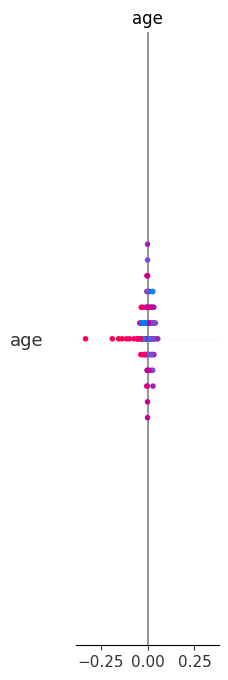

In [12]:
import shap

# Use KernelExplainer as an alternative
explainer = shap.KernelExplainer(model2.predict, shap.sample(X_train, 100))
shap_values = explainer.shap_values(shap.sample(X_val, 100), nsamples=100)  # Limit samples to manage computation

# Plot the SHAP values
shap.summary_plot(shap_values, shap.sample(X_val, 100))


In [13]:
from tensorflow.keras.models import Model

# Create a new model that outputs logits if your original model ends with a sigmoid activation
logit_model = Model(inputs=model2.inputs, outputs=model2.layers[-2].output)

# Now use DeepExplainer with the logit model
explainer = shap.DeepExplainer(logit_model, X_train[:100])
shap_values = explainer.shap_values(X_val[:100])
shap.summary_plot(shap_values[0], X_val[:100], feature_names=X_val.columns)


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AttributeError: 'tuple' object has no attribute 'as_list'

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 650us/step


  1%|          | 1/100 [00:07<12:25,  7.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step


  2%|▏         | 2/100 [00:14<11:49,  7.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step


  3%|▎         | 3/100 [00:21<11:35,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step


  4%|▍         | 4/100 [00:28<11:15,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step


  5%|▌         | 5/100 [00:35<11:00,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step


  6%|▌         | 6/100 [00:42<10:48,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 657us/step


  7%|▋         | 7/100 [00:49<10:44,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 623us/step


  8%|▊         | 8/100 [00:55<10:33,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step


  9%|▉         | 9/100 [01:02<10:24,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 631us/step


 10%|█         | 10/100 [01:09<10:18,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step


 11%|█         | 11/100 [01:16<10:11,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 657us/step


 12%|█▏        | 12/100 [01:23<10:08,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 626us/step


 13%|█▎        | 13/100 [01:30<09:59,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step


 14%|█▍        | 14/100 [01:37<09:50,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 638us/step


 15%|█▌        | 15/100 [01:44<09:45,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 621us/step


 16%|█▌        | 16/100 [01:51<09:40,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step


 17%|█▋        | 17/100 [01:57<09:29,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 626us/step


 18%|█▊        | 18/100 [02:04<09:21,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 618us/step


 19%|█▉        | 19/100 [02:11<09:12,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 622us/step


 20%|██        | 20/100 [02:18<09:03,  6.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step


 21%|██        | 21/100 [02:25<09:02,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 615us/step


 22%|██▏       | 22/100 [02:31<08:52,  6.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 618us/step


 23%|██▎       | 23/100 [02:38<08:43,  6.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 616us/step


 24%|██▍       | 24/100 [02:45<08:35,  6.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step


 25%|██▌       | 25/100 [02:52<08:33,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step


 26%|██▌       | 26/100 [02:59<08:38,  7.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step


 27%|██▋       | 27/100 [03:06<08:26,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 636us/step


 28%|██▊       | 28/100 [03:13<08:18,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 632us/step


 29%|██▉       | 29/100 [03:20<08:09,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 645us/step


 30%|███       | 30/100 [03:27<08:02,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 674us/step


 31%|███       | 31/100 [03:34<08:00,  6.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 636us/step


 32%|███▏      | 32/100 [03:41<07:51,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step


 33%|███▎      | 33/100 [03:47<07:42,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 658us/step


 34%|███▍      | 34/100 [03:54<07:38,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 632us/step


 35%|███▌      | 35/100 [04:01<07:29,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 627us/step


 36%|███▌      | 36/100 [04:08<07:23,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 632us/step


 37%|███▋      | 37/100 [04:15<07:16,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 677us/step


 38%|███▊      | 38/100 [04:22<07:15,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step


 39%|███▉      | 39/100 [04:29<07:02,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 650us/step


 40%|████      | 40/100 [04:36<06:56,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 624us/step


 41%|████      | 41/100 [04:43<06:46,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 614us/step


 42%|████▏     | 42/100 [04:50<06:36,  6.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step


 43%|████▎     | 43/100 [04:56<06:28,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 610us/step


 44%|████▍     | 44/100 [05:03<06:19,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 611us/step


 45%|████▌     | 45/100 [05:10<06:11,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step


 46%|████▌     | 46/100 [05:17<06:06,  6.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 636us/step


 47%|████▋     | 47/100 [05:24<06:02,  6.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 681us/step


 48%|████▊     | 48/100 [05:31<06:00,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step


 49%|████▉     | 49/100 [05:38<05:52,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 675us/step


 50%|█████     | 50/100 [05:45<05:49,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 628us/step


 51%|█████     | 51/100 [05:52<05:39,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step


 52%|█████▏    | 52/100 [05:58<05:32,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 615us/step


 53%|█████▎    | 53/100 [06:05<05:23,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step


 54%|█████▍    | 54/100 [06:12<05:16,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 627us/step


 55%|█████▌    | 55/100 [06:19<05:10,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step


 56%|█████▌    | 56/100 [06:26<05:02,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step


 57%|█████▋    | 57/100 [06:33<04:55,  6.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step


 58%|█████▊    | 58/100 [06:40<04:47,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 638us/step


 59%|█████▉    | 59/100 [06:47<04:42,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 640us/step


 60%|██████    | 60/100 [06:53<04:35,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 624us/step


 61%|██████    | 61/100 [07:00<04:27,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 627us/step


 62%|██████▏   | 62/100 [07:07<04:20,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step


 63%|██████▎   | 63/100 [07:14<04:12,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 623us/step


 64%|██████▍   | 64/100 [07:21<04:05,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 621us/step


 65%|██████▌   | 65/100 [07:28<04:00,  6.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 628us/step


 66%|██████▌   | 66/100 [07:34<03:53,  6.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 618us/step


 67%|██████▋   | 67/100 [07:41<03:45,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 619us/step


 68%|██████▊   | 68/100 [07:48<03:37,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 647us/step


 69%|██████▉   | 69/100 [07:55<03:32,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 650us/step


 70%|███████   | 70/100 [08:02<03:26,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step


 71%|███████   | 71/100 [08:09<03:20,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 635us/step


 72%|███████▏  | 72/100 [08:16<03:13,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step


 73%|███████▎  | 73/100 [08:23<03:07,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 635us/step


 74%|███████▍  | 74/100 [08:30<03:00,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 5s 695us/step


 75%|███████▌  | 75/100 [08:37<02:56,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step


 76%|███████▌  | 76/100 [08:44<02:48,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 643us/step


 77%|███████▋  | 77/100 [08:51<02:41,  7.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 632us/step


 78%|███████▊  | 78/100 [08:58<02:33,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 645us/step


 79%|███████▉  | 79/100 [09:05<02:26,  6.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 626us/step


 80%|████████  | 80/100 [09:12<02:18,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 641us/step


 81%|████████  | 81/100 [09:19<02:11,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 633us/step


 82%|████████▏ | 82/100 [09:25<02:04,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 654us/step


 83%|████████▎ | 83/100 [09:32<01:58,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 669us/step


 84%|████████▍ | 84/100 [09:40<01:52,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 637us/step


 85%|████████▌ | 85/100 [09:47<01:45,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 678us/step


 86%|████████▌ | 86/100 [09:54<01:40,  7.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 5s 689us/step


 87%|████████▋ | 87/100 [10:02<01:35,  7.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 5s 704us/step


 88%|████████▊ | 88/100 [10:09<01:27,  7.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 658us/step


 89%|████████▉ | 89/100 [10:16<01:20,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 5s 701us/step


 90%|█████████ | 90/100 [10:24<01:12,  7.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 640us/step


 91%|█████████ | 91/100 [10:31<01:04,  7.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 656us/step


 92%|█████████▏| 92/100 [10:38<00:57,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 651us/step


 93%|█████████▎| 93/100 [10:45<00:49,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step


 94%|█████████▍| 94/100 [10:52<00:43,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 5s 693us/step


 95%|█████████▌| 95/100 [10:59<00:36,  7.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 637us/step


 96%|█████████▌| 96/100 [11:06<00:28,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 639us/step


 97%|█████████▋| 97/100 [11:14<00:21,  7.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 671us/step


 98%|█████████▊| 98/100 [11:21<00:14,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step


 99%|█████████▉| 99/100 [11:28<00:07,  7.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step


100%|██████████| 100/100 [11:35<00:00,  6.95s/it]


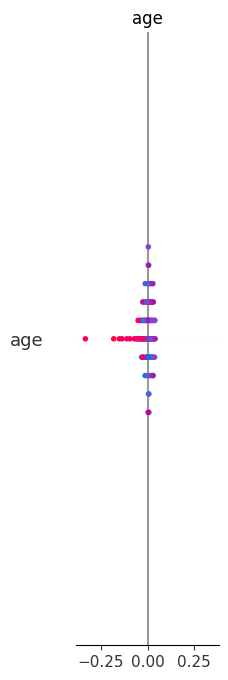

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 10

In [14]:
import shap

# Use KernelExplainer with a representative sample
background = shap.sample(X_train, 100)  # Adjust size based on your dataset and compute capacity
explainer = shap.KernelExplainer(model2.predict, background)

# Calculate SHAP values for a sample of the validation data
val_sample = shap.sample(X_val, 100)  # Keeping it manageable
shap_values = explainer.shap_values(val_sample, nsamples='auto')

# Summary plot
shap.summary_plot(shap_values, val_sample, feature_names=X_val.columns)

# Dependence plot for a specific feature
feature_index = 1  # Change index based on feature of interest
shap.dependence_plot(feature_index, shap_values, val_sample, feature_names=X_val.columns)

# Force plot for a single prediction
instance_index = 0  # Change index to explore other predictions
shap.force_plot(explainer.expected_value, shap_values[instance_index,:], val_sample.iloc[instance_index,:], feature_names=X_val.columns)
